# Reproduction of the paper: The Principle of Maximum Causal Entropy for Estimationg Interacting Process

Using the theory developed in the paper for rational behavior in multi-player games, we reproduce the experiments in Section 14.1 of Modeling Purposeful Adaptive Behavior with the Principle of Maximum Causal Entropy. These experiment are for the purpose of the robust prediction of rational behavior in stochastic games. In a short word, we know the utility for each player in each state, and then we predict the rational behavior of them in a Markov game.

Instead of using the chain rule: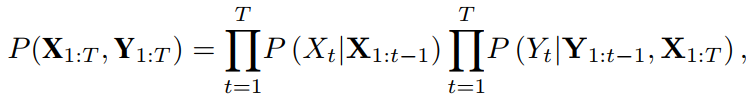

Brian purposes an alternative decomposition :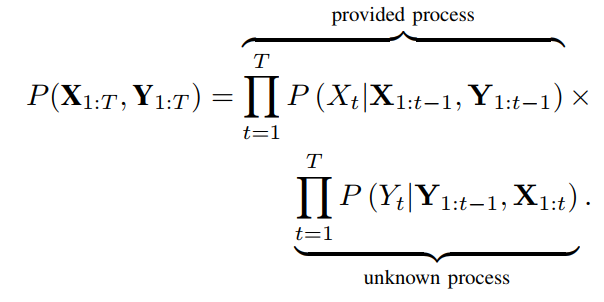

Based on this decomposition, the causal conditioned entropy of Y given X is:
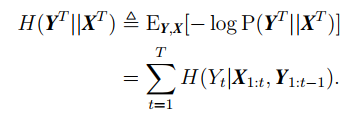

With theory of Maximum Causal Entropy Correlated Equilibria instead of the theory of Maximum Entropy, he changes the conditioned equrilibrium problem into a convex optimization proble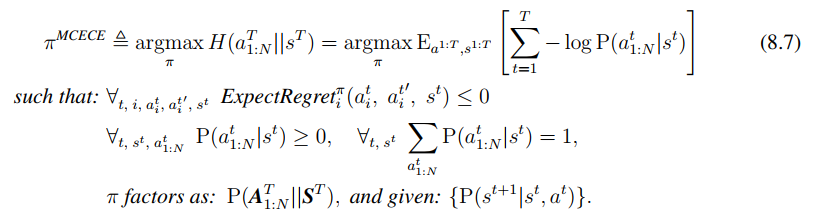

where the  ExpeceRegret can be calculted by: 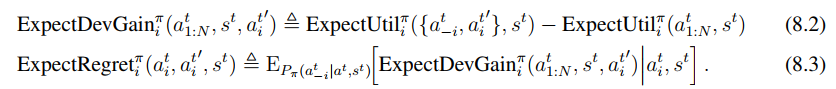

To solve this opimization problem, they take the advantage of Lagrangian: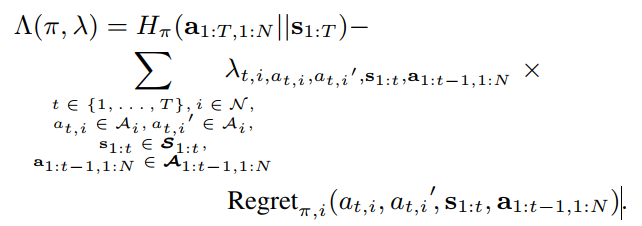 Note that, in the Lagrangian they suppress the the probabilistic positivity constraints and normalization constraints with the understanding that the resulting probability distribution must normalize to 1.

By taking the partial derivative and equating it to zero, they can obtain the relationship between $\pi$ and $\lambda$, the partial derivative is :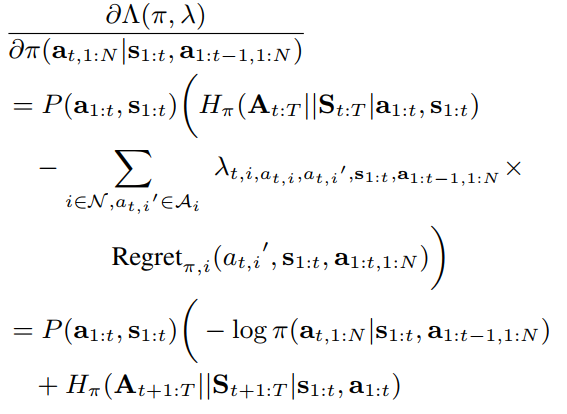

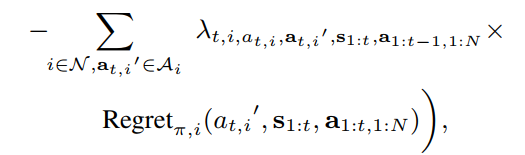

Thus, the relationship is that :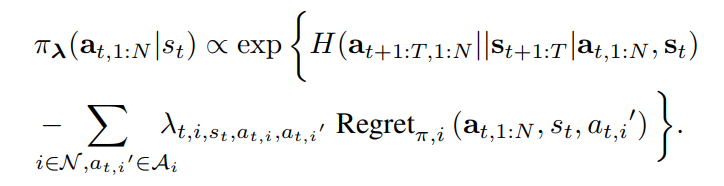

$\pi$ can be expressed as: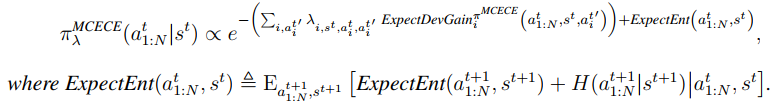

## Experimental Setup

For each of |S| states in the Markov game, each of N players has |A| actions to choose from (for a total of $|A|^{N}$ joint actions). The state transition dynamics, ${P(s_{t+1}|s_{t}; a_{1: t}^{N})}$, depend on the combination of players’ actions (and state) and are drawn uniformly from the simplex of probabilities.  The utility obtained by each player in each state, $Utility_{i}(s)$, is drawn uniformly from{0,0.1, 0.2, ... , 0:9}. For our experiments, we allow either the number of states to vary with 2 actions and 3 players; or the number of players to vary for random Markov games with 2 states and 2 actions. In both cases, we employ a discount factor of γ = 0:75. We consider a fixed time horizon of T = 10 time steps for our experiments.

## Numerical experiment


At first, we consider 2 states, 2 actions and 3 players. At first we import some necessory modules and packages.

In [1]:
import random
import numpy as np
import math



Then, we define the $Utility_{i}(s)$ . Note that the $Utility_{i}(s)$ can be seen as a 2-dimensional matrix, with N rows and |S| columns. The random seed is set to 42. 

In [2]:
size_players = 3 #player数
size_states = 2 #状态数
size_all_states = size_states**size_players #联合状态的总数
size_actions = 2 #行为数
size_all_actions = size_actions**size_players #联合行为的总数
T = 5 #time horizon
gamma = 0.75 #折扣参数
Utility = np.random.randint(0, 10, size=(size_players, size_states))/10#定义对于每个player，每个状态的utility
s_0 = 0 #初始状态，初始行为

func_f = np.zeros((size_actions,size_actions-1),dtype = int)
for i in range(size_actions):
    k = 0
    for j in range(size_actions):     
        if j != i :
            func_f[i][k] = j
            k += 1


The algorithm we use is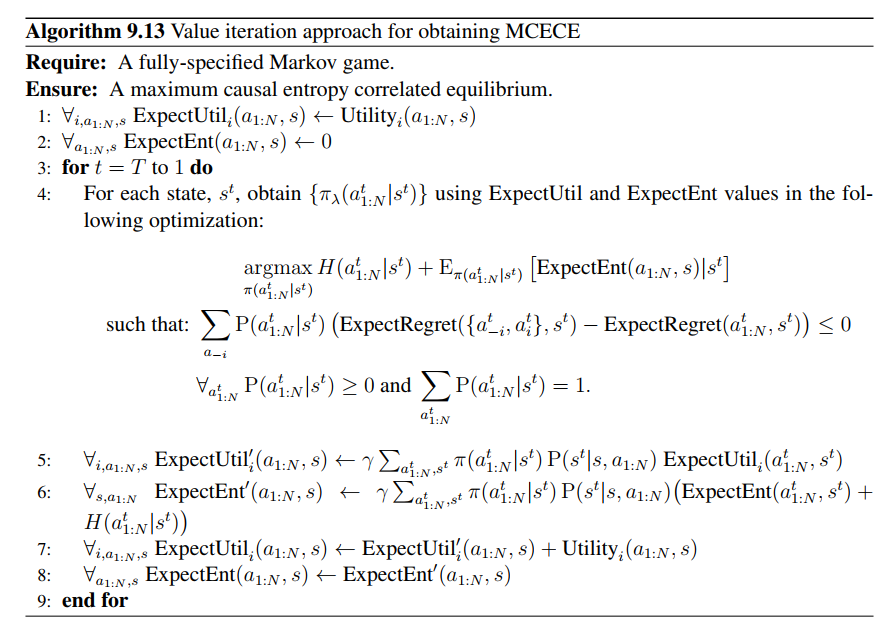

Consider the step 4 in the algorithm. Since $\pi$ is determined by $\lambda$.We use the sub-gradient algorithm to select the optimal $\lambda$. The gradient is calculated by: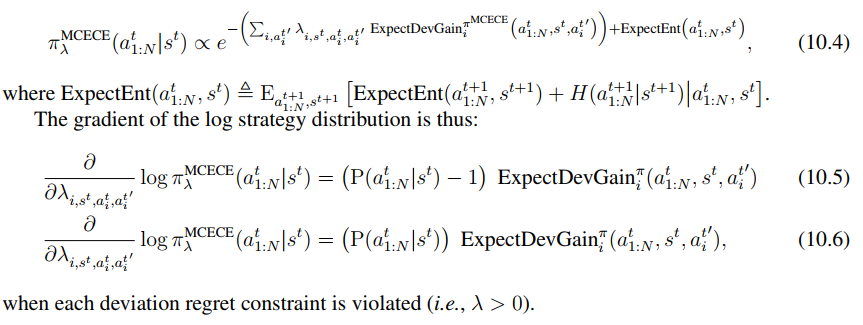

where the ExpectDevGain can be calculated by :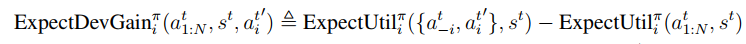

The sub-gradient algorithm for a convex optimization problem :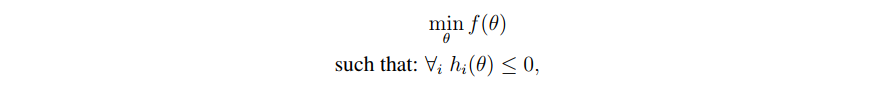

is that: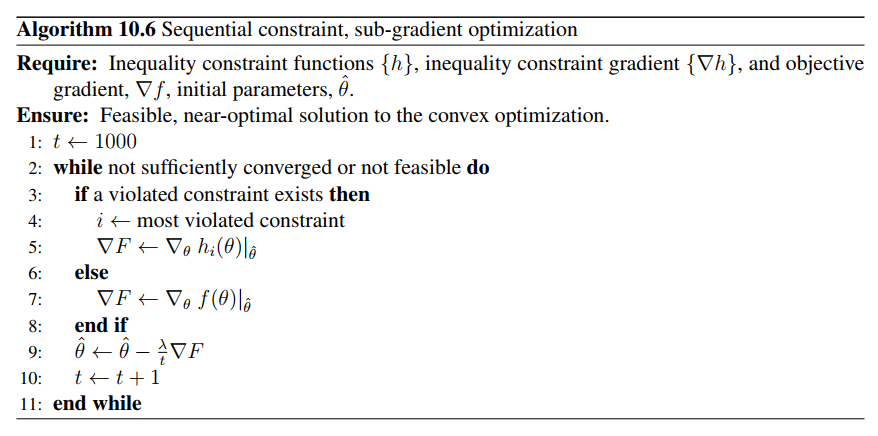

In [ ]:
#函数定义
def uniform_simplex(N):
    "定义从单纯形概率中均匀采样出概率分布的函数，作为P(st+1|st,a), N为目标概率分布的变量数"
    X = np.zeros(N+1)
    Z = np.zeros(N)
    X[0] = 0
    for i in range(N-1):
        X[i+1] = random.uniform(0,1)
    X[N] = 1
    X.sort()

    for i in range(N):
        Z[i] = X[i+1] - X[i]
    return Z

def trans(n,deci,result=[]):
    "将十进制数据变为一组n进制数组，如deci=4时123->[1,3,2,3],意味着123的四进制表示为1323"
    multiple = n//deci
    reminder = n%deci
    result.insert(0,reminder)
    if (multiple!=0):
        trans(multiple,deci,result)
    return result

def decode(n,deci,leng):
    "状态空间解码函数，将一个整数映射为对应的路径例如deci=4,length=7时：123-> [0,0,0,1,3,2,3]"
    action=trans(n,deci,[])
    while(len(action) < leng):
        action.insert(0,0)
    return np.array(action) 

def encode(deci,list):
    "状态空间解码函数，将对应的路径映射为一个整数例如,deci=4时： [0,0,0,1,3,2,3]->123"
    n = 0
    for i in range(len(list)):
        n += list[i]*(deci**(len(list)-i-1))
    return n

P_sa_s = np.zeros((size_all_states,size_all_actions,size_all_states))#Pi(st+1|st,a)
for i in range(size_all_states):
    for j in range(size_all_actions):
            P_sa_s[i][j]= uniform_simplex(size_all_states)





def Joint_distribution_cal(t_horizon,s_list,a_list,s0,a0,Pai_MCECE):
    "计算根据策略方案以及转移概率计算联合分布,t0初始时刻，T结束时刻，s_vec状态的集合（s(t0:T)）,a_vec行为的集合"
    

    P = 1
    for t in range(t_horizon):
        s1 = s_list[t]
        a1 = a_list[t]
        P *= P_sa_s[s0][a0][s1]*Pai_MCECE[s1][a1] #计算p_sa_s
       
        s0 = s1
        a0 = a1
        
    return P



        
def ExpectDevGain(i,a,s,a_change_index,ExpectUtil):
    a_list = decode(a,size_actions,size_players)
    
    a_list[i] = func_f[a_list[i]][a_change_index]
    
    a_new = encode(size_actions,a_list)
    ExpectDev = ExpectUtil[i][s][a] - ExpectUtil[i][s][a_new]
    return ExpectDev


def grad_cal(i,s,a,a_change_index,Pai_MCECE,ExpectUtil):
    "求梯度"
    ExpectDev = ExpectDevGain(i,a,s,a_change_index,ExpectUtil)
    if ExpectDev<1:
        grad= (Pai_MCECE[s][a]-1)*ExpectDev
    else:
        grad = Pai_MCECE[s][a]*ExpectDev
    return grad

def subgrad_alg(lam_ini,Pai_MCECE,ExpectUtil):
    "subgradient algorithm theta_ini是参数theta的初始值,返回最优的lam"            
    theta = lam_ini
    dec = 3
    flag = 0
    min_t = 1100
    for t in range(1000,1500):
        for i in range(size_players):   
            for s in range(size_all_states):
                for a in range(size_all_actions):
                    for a_change_index in range(size_actions-1) :
                        if theta[i][s][a][a_change_index] <0:
                            theta[i][s][a][a_change_index] += dec/t 
                            flag = 1
                        else :
                            theta[i][s][a][a_change_index] -= grad_cal(i,s,a,a_change_index,Pai_MCECE,ExpectUtil) * dec/t
        if flag == 0 & t >= min_t:
            break
    return theta
    
def Pai_cal(lam,ExpectEnt,ExpectUtil):
    "根据lambada值得出Pai分布"

    Pai_MCECE = np.zeros((size_all_states,size_all_actions))#初始化决策
    for s in range(size_all_states):
        sum_Pai = 0
        for a in range(size_all_actions):
            sum_lam = 0
            for i in range(size_players):
                for a_change_index in range(size_actions-1) :
                    sum_lam += lam[i][s][a][a_change_index]*ExpectDevGain(i,a,s,a_change_index,ExpectUtil)  
            Pai_MCECE[s][a] = math.exp(-1*sum_lam+ExpectEnt[s][a])
            sum_Pai += Pai_MCECE[s][a]
        Pai_MCECE[s] /= sum_Pai

    return Pai_MCECE

def RWS(distribution):
    #轮盘赌采样
    rand = random.random()
    pos = 0
    for i in range(len(distribution)):
        pos += distribution[i]
        if (rand <= pos):
            return i

#程序
Utility = np.random.randint(0, 10, size=(size_players, size_states))/10#定义对于每个player，每个状态的utility

ExpectUtil_val = np.ones((size_players,size_all_states,size_all_actions))
for i in range(size_players):
    for j in range(size_all_states):
        s_list = decode(j,size_states,size_players)
        ExpectUtil_val[i][j] *= Utility[i][s_list[i]]


ExpectEnt_val = np.zeros((size_all_states,size_all_actions)) 

lam_val = np.ones((size_players,size_all_states,size_all_actions,size_actions-1))*0.5#初始化lambda
Pai_MCECE_val = Pai_cal(lam_val,ExpectEnt_val,ExpectUtil_val)

for time in range(T):
    t = T - time
    lam_val = subgrad_alg(lam_val,Pai_MCECE_val,ExpectUtil_val)
    Pai_MCECE_val = Pai_cal(lam_val,ExpectEnt_val,ExpectUtil_val)
    for s in range(size_all_states):
        for a in range(size_all_actions):
            s_list = decode(s,size_states,size_players)
            for s_t in range(size_all_states):
                for a_t in range(size_all_actions):
                    for i in range(size_players):
                        ExpectUtil_val[i][s][a] += gamma*Pai_MCECE_val[s_t][a_t]*P_sa_s[s][a][s_t]*ExpectUtil_val[i][s_t][a_t]
                        
                    ExpectEnt_val[s][a] += gamma*Pai_MCECE_val[s_t][a_t]*P_sa_s[s][a][s_t]*(ExpectEnt_val[s_t][a_t]-Pai_MCECE_val[s_t][a_t]*P_sa_s[s][a][s_t]*math.log(Pai_MCECE_val[s_t][a_t]))
                        
                        #print(ExpectEnt_val[s][a])
            print(ExpectEnt_val[0][0])
            for i in range(size_players):
                s_i = s_list[i]
                ExpectUtil_val[i][s][a] += Utility[i][s_i]
                
lam_val = subgrad_alg(lam_val,Pai_MCECE_val,ExpectUtil_val)
Pai_MCECE_val = Pai_cal(lam_val,ExpectEnt_val,ExpectUtil_val)    
np.save('Pai_MCECE_val.npy',Pai_MCECE_val)




s_0 =0
a_0 = RWS(Pai_MCECE_val[s_0])


sum_bit = 0


for t in range(T):
    t += 1
    for s in range(size_all_states**t):
        s_list = decode(s,size_all_states,t)#解码成时序状态     
        for a in range(size_all_actions**t):
            a_list = decode(a,size_all_actions,t)#解码成时序行为
            P = Joint_distribution_cal(t,s_list,a_list,s_0,int(a_0),Pai_MCECE_val)
            sum_P_as = -1 * math.log(Pai_MCECE_val[s_list[t-1]][a_list[t-1]],2)
            sum_bit += P*sum_P_as
print(sum_bit)  

    

